In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



%matplotlib inline

In [95]:
data = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv"

In [96]:
!wget $data 

--2025-10-08 19:57:05--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.3’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.009s  

2025-10-08 19:57:05 (89.4 MB/s) - ‘car_fuel_efficiency.csv.3’ saved [874188/874188]



In [97]:
df_full = pd.read_csv('car_fuel_efficiency.csv')

In [101]:
df = df_full[['engine_displacement','horsepower','vehicle_weight','model_year','fuel_efficiency_mpg']]

In [102]:
df

engine_displacement  horsepower  vehicle_weight  model_year  \
0                     170       159.0     3413.433759        2003   
1                     130        97.0     3149.664934        2007   
2                     170        78.0     3079.038997        2018   
3                     220         NaN     2542.392402        2009   
4                     210       140.0     3460.870990        2009   
...                   ...         ...             ...         ...   
9699                  140       164.0     2981.107371        2013   
9700                  180       154.0     2439.525729        2004   
9701                  220       138.0     2583.471318        2008   
9702                  230       177.0     2905.527390        2011   
9703                  270       140.0     2908.043477        2005   

      fuel_efficiency_mpg  
0               13.231729  
1               13.688217  
2               14.246341  
3               16.912736  
4               12.488369  
...                   ...  
9699            15.101802  
9700            17.962326  
9701            17.186587  
9702            15.331551  
9703            14.884467  

[9704 rows x 5 columns]

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

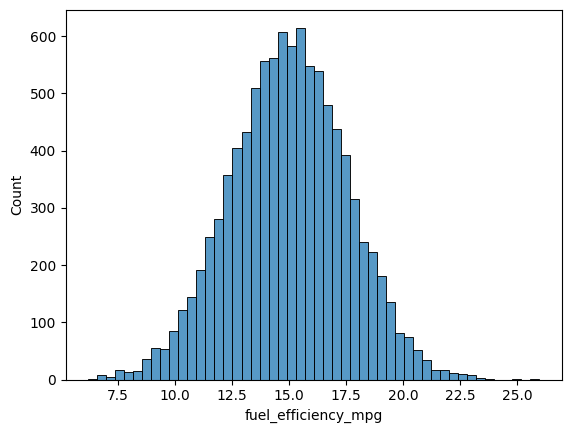

In [103]:
sns.histplot(df.fuel_efficiency_mpg, bins=50)

In [104]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [105]:
median = df["horsepower"].median()
print(median)

149.0


In [106]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [107]:
idx = np.arange(n)

In [108]:
np.random.seed(42)

In [109]:
np.random.shuffle(idx)

In [110]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [111]:
# Features
X_train = df_train[["horsepower"]].copy()
y_train = df_train["fuel_efficiency_mpg"].copy()

X_val = df_val[["horsepower"]].copy()
y_val = df_val["fuel_efficiency_mpg"].copy()

In [112]:
# ----- Option 1: fill missing horsepower with 0 -----
X_train_0 = X_train.copy()
X_val_0   = X_val.copy()

X_train_0["horsepower"] = X_train_0["horsepower"].fillna(0)
X_val_0["horsepower"]   = X_val_0["horsepower"].fillna(0)

m0 = LinearRegression()
m0.fit(X_train_0, y_train)

pred0 = m0.predict(X_val_0)
rmse0 = mean_squared_error(y_val, pred0)
print("RMSE (fill with 0):", round(rmse0, 2))


RMSE (fill with 0): 6.99


In [113]:
# ----- Option 2: fill missing horsepower with MEAN computed on TRAIN ONLY -----
X_train_m = X_train.copy()
X_val_m   = X_val.copy()

hp_mean = X_train_m["horsepower"].mean()

X_train_m["horsepower"] = X_train_m["horsepower"].fillna(hp_mean)
X_val_m["horsepower"]   = X_val_m["horsepower"].fillna(hp_mean)

m_mean = LinearRegression()
m_mean.fit(X_train_m, y_train)

predm = m_mean.predict(X_val_m)
rmsem = mean_squared_error(y_val, predm)
print("RMSE (fill with mean):", round(rmsem, 2))



RMSE (fill with mean): 6.97


In [114]:
# Function for splitting and shuffling data
def shuffle_data(df, seed):
    """
    This function splits the data into train - validation - test sets with
    respectively 60% - 20% - 20% of the original dataframe, shuffles the obtained sets,
    and returns them with new index.
    ---
    df: dataframe
    seed: numpy seed for reproducibility
    """
    # Data set size
    n = len(df)
    # Validation and Test Size
    n_val = n_test = int(n * 0.2)
    # Train set size
    n_train = n - (n_val * 2)
    
    # Create an index
    idx = np.arange(n)
    # Shuffle the index
    np.random.seed(seed) # for reproducibility
    np.random.shuffle(idx)

    # Train - Val - Test splitting
    df_train = df.iloc[idx[ : n_train]]
    df_val = df.iloc[idx[n_train : n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val : ]]

    # Reset indexes
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)
    df_test.reset_index(drop = True, inplace = True)

    # return shuffled data
    return df_train, df_val, df_test
    
# Data Preparation Function
def prepare_X(df, fill_value = 0):
    """
    This function prepares a feature matrix `X`.
    ---
    df: dataframe,
    fill_value: value used for filling missing values if any.
        default: `0`
        Otherwise, please preferably enter a dictionnary or a single value.
    """
    # Remove target feature
    df_num = df.drop(columns = "fuel_efficiency_mpg")

    # Filling missing values
    df_num = df_num.fillna(fill_value)

    # Extract an array
    X = np.array(df_num)

    # return feature matrix
    return X
    
# Linear regression model traininng

def train_linear_regression(X, y, r = 0):
    """
    Function to train a linear regression model.
    ---
    X: Feature matrix
    y: target vector
    r: regularization parameter if any,
        defalut value: 0 (no regularization)
    """
    # X_0 vector
    ones = np.ones(X.shape[0])   
    # Feature matrix
    X = np.column_stack([ones, X])
    
    # Gram matrix
    XTX = X.T.dot(X)
    # Regularization
    XTX = XTX + r * np.eye(XTX.shape[0])
    # Gram matrix inverse
    XTX_inv = np.linalg.inv(XTX)
    
    # Weights
    w_full = XTX_inv.dot(X.T).dot(y)

    # return slope and coefficients
    return w_full[0], w_full[1 :]
    
# Root Mean Square Root Error Function

def rmse(y, y_pred):
    """
    Root Mean Square Error between real values and model predictions.
    ---
    y: real values
    y_pred: model predictions
    """
    # Square errors
    se = (y - y_pred) ** 2

    # Mean square error
    mse = se.mean()

    # return root mean square error
    return np.sqrt(mse)

In [115]:
# Funtion to evaluate the model
def evaluate_model(train, val, fill_value = 0, r = 0):
    """
    This function evaluates a linear regression model by returning a rounded rmse.
    ---
    train: training dataframe 
    val: validation dataframe
    fill_value: value used for filling missing values if any,
        default: `0`,
        Otherwise, please preferably enter a dictionnary or a single value
    r: regularization parameter for linear regression
    """
    # Extract targets
    y_train = train.fuel_efficiency_mpg.values
    y_val = val.fuel_efficiency_mpg.values
    
    # Prepare training data
    X_train = prepare_X(train, fill_value)
    
    # Linear Regression
    w0, w = train_linear_regression(X_train, y_train, r)
    
    # Prepare validation data
    X_val = prepare_X(val, fill_value)
    
    # Make predictions on validation data
    y_pred = w0 + X_val.dot(w)
    
    # Rounded RMSE on validation data
    score = rmse(y_val, y_pred)

    # return score
    return round(score, 3)

In [120]:
# values for the parameters
params = [0, 0.01, 0.1, 1, 5, 10, 100]

# Initialize results
results = []

# Model Fine Tuning with parameters
for param in params:
    # store model evaluation score into results
    results += [evaluate_model(train = df_train, val = df_val, fill_value = 0, r = param)]

# Visualize the results
pd.Series(data = results, index = params, name = "parameters_results")

0.00      0.513
0.01      0.513
0.10      0.516
1.00      0.520
5.00      0.520
10.00     0.521
100.00    0.521
Name: parameters_results, dtype: float64

In [121]:
# question 5 
# 0-9 seeds
seeds = list(range(10))

# Initialize results
results = []

# Model Fine Tuning with data splitting
for s in seeds:
    # Train - Validation - test
    df_train, df_val, df_test = shuffle_data(df = df, seed = s)

    # store model evaluation score into results
    results += [evaluate_model(train = df_train, val = df_val, fill_value = 0, r = 0)]

# Visualize the results
rmse_seeds = pd.Series(data = results, index = seeds, name = "seeds_results")
rmse_seeds

0    0.521
1    0.521
2    0.523
3    0.516
4    0.511
5    0.528
6    0.531
7    0.509
8    0.515
9    0.513
Name: seeds_results, dtype: float64

In [118]:
# Standard deviation of all scores
std = np.std(rmse_seeds)
round(std, 3)

np.float64(0.007)

In [119]:
# question 6
# Train - Validation - test with a seed of `9`
df_train, df_val, df_test = shuffle_data(df = df, seed = 9)

# Combine Training and Validation sets
df_full_train = pd.concat([df_train, df_val])

# model evaluation score on the test dataset
evaluate_model(train = df_full_train, val = df_test, fill_value = 0, r = 0.001)

np.float64(0.516)